# A simple Product Recommendation process basd on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project and practical application

Any decent recommender model would have been trained using data from millions of products. For companies like Amazon, sich large amounts of data is easy to come by. But that's not all now is it? Can the same recommender model be used for years at a stretch without any modifications? Probably not. Products evolve over time. Companies do away with older products and bring in  newer ones every day. Companies like Amazon have the time and resources to ensure that their recommendation systems are up to date with the latest trends.

Moreover, neural networks are being used for recommender systems. These models are designed using sophisticated state of the art architecture. The model needs to be designed first. Then it will be tested and modified again and again. Fine tuning deep learning models can be a monumental task. Now, what if I told you that we could come up with a decent recommender process that involves no training at all? Sounds too good to be true? Well, thanks to __[Google's universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ , this is possible! Given a product description as text, the input will be mapped to a high dimensional vector of length 512. These "embeddings" are then used to compute similarities based on which practical recommendations can be made

### Outline of the entire process:

1. Obtain the data from this __[webiste](http://jmcauley.ucsd.edu/data/amazon/links.html)__ and more specifically, this  __[link](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Home_and_Kitchen.json.gz)__ for the data.
2. Clean the data for analysis.
3. Remove stop words from product descriptions.
4. Convert the descriptions column to a list and have that run through __[Tensorflow's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ . This computes a numpy array of length 512 for each movie plot.
5. Calculate the cosine similarities matrix using the above generated numpy array for the 9 most similar product descriptions.
6. Plot the images of the movies using the url in the source file.
7. Analyze genres and possibly the plot descriptions as well.

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

### STEP 1

In [2]:
new_df = pd.read_csv('home_kitchen.csv')

In [3]:
#Inspecting the structure of the file
new_df.head()

,imUrl,title,description_final
0,http://ecx.images-amazon.com/images/I/41MXBRGC...,Johnson Brothers Friendly Village 8-Inch Veget...,friendly village johnson brothers introduced b...
1,http://ecx.images-amazon.com/images/I/41tRnWfb...,SHARP Plasmacluster Air Ionizer IG-CM1 B Black...,sharp's exclusive highly esteemed plasmacluste...
2,http://ecx.images-amazon.com/images/I/31ummNI9...,"Noritake Colorwave Floral Bowl, 4-Inch, Chocol...",colorwave chocolate mattetextured deep colorat...
3,http://ecx.images-amazon.com/images/I/41C94YPJ...,"Riedel Vinum Spirits Glasses, Set of 2",renowned austrian glassmaker riedel designs sh...
4,http://ecx.images-amazon.com/images/I/41q3F3CQ...,Make My Day 9-1/2-Ounce Ceramic Hot Beverage C...,enjoy daily fix coffee tea style hip practical...


In [7]:
len(new_df)

52295

We will now only choose the fields of interest

In [5]:
new_df = new_df.dropna()

In [9]:
len(new_df)

51588

In [6]:
new_df = new_df.reset_index(drop=True)

In [11]:
new_df.to_csv('all_true.csv')

Dropping rows with NaN values

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [13]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [14]:
all_descriptions = new_df['description_final'].tolist()

In [15]:
len(all_descriptions)

51588

In [16]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [17]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:30000]
set_4 = all_descriptions[30000:40000]
set_5 = all_descriptions[40000:50000]
set_6 = all_descriptions[50000:]
full_set = [set_1, set_2, set_3, set_4, set_5, set_6]

In [18]:
j=0
for i in full_set:
    j += 1
    with tf.device('/device:CPU:0'):      
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i))
            np.save('kitchen_home_set_' + str(j) + '.npy', description_embeddings)            
            print(j)

1
2
3
4
5
6


In [19]:
kitchen_embed_set_1 = np.load('kitchen_home_set_1.npy')
kitchen_embed_set_2 = np.load('kitchen_home_set_2.npy')
kitchen_embed_set_3 = np.load('kitchen_home_set_3.npy')
kitchen_embed_set_4 = np.load('kitchen_home_set_4.npy')
kitchen_embed_set_5 = np.load('kitchen_home_set_5.npy')
kitchen_embed_set_6 = np.load('kitchen_home_set_6.npy')

In [20]:
full_set = np.concatenate([kitchen_embed_set_1, kitchen_embed_set_2, kitchen_embed_set_3, kitchen_embed_set_4, kitchen_embed_set_5, kitchen_embed_set_6])

In [21]:
len(full_set)

51588

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [22]:
cos_matrix = cosine_similarity(full_set)

In [23]:
cos_matrix.shape

(51588, 51588)

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [24]:
words_siilar = cos_matrix

In [25]:
words_siilar.shape

(51588, 51588)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [26]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [27]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

I've added code to record the index number of the product descriptions.

In [29]:
new_df['description_final'].loc[32292]

'optimus brings finest fans heaters h infrared quartz heater furniture grade wood cabinet features include wheel base easy movement two heat settings watt automatic thermostat control overheat thermal cutoff hour timer comes remote control'

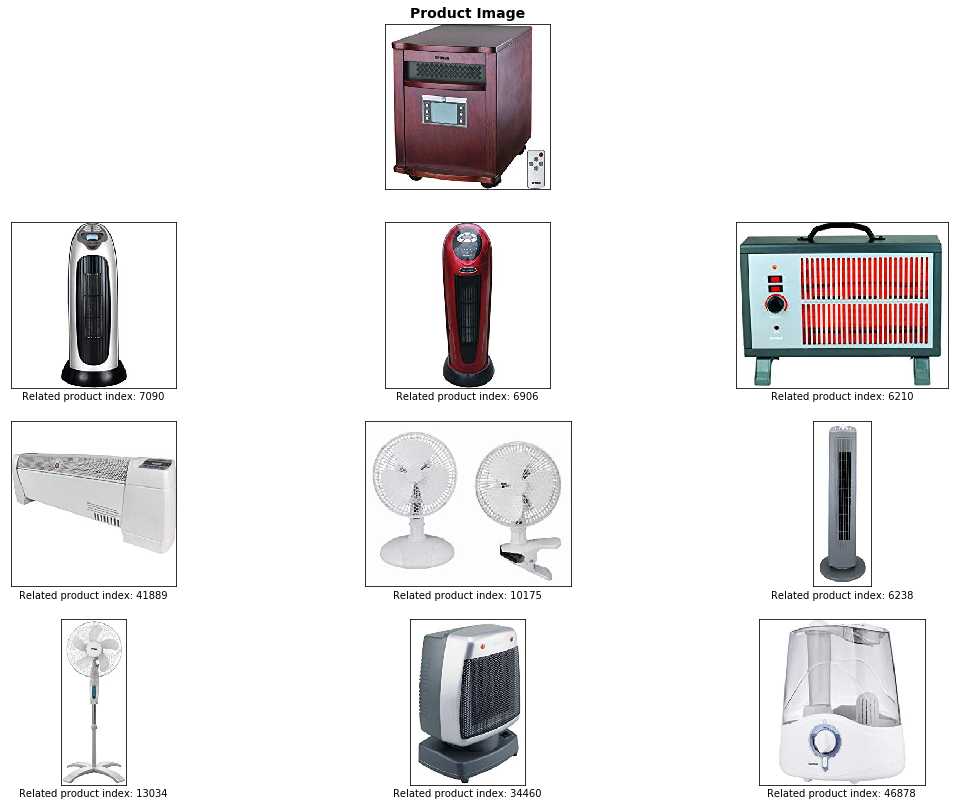

In [30]:
get_related_products(32292)

In [35]:
nums = [6906, 19585, 2354, 28281, 46620, 19817]

In [36]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

6906 Optimus H-7328 Portable 22-Inch Oscillating Tower Heater with Digital Temperature Readout and Remote Control

19585 Comfort Zone&reg; Deluxe Oil Filled Radiator Heater  CZ7007

2354 Real Flame Ashley Electric Fireplace in Black Wash

28281 Panasonic Standard Air Conditioner, 7,800 Btu

46620 Dimplex Compact Electric Stove (CS3311)

19817 HOLMES HFH131UM Personal Fan Heater with Manual Controls



In [62]:
new_df.loc[new_df.title.str.contains('grinder')]

,imUrl,title,description_final
1580,http://ecx.images-amazon.com/images/I/510pNu31...,Oster 24546 coarse disc for meat grinder.,disc fits oster kitchen center meat grinder at...
37350,http://ecx.images-amazon.com/images/I/41dQNjom...,(3) size #12 Sausage Stuffing Stuffer tubes fo...,pack size # stainless steel premium sausage st...
37649,http://ecx.images-amazon.com/images/I/3154GJ4D...,Bodum coffee grinder black 5679-01 BK,size x inches model number&#xff a; bk
40368,http://ecx.images-amazon.com/images/I/41Kb7d-P...,Capresso CoffeeTeam Therm Coffee Machine w/gri...,&#x ; choose cups select mild regular strong p...


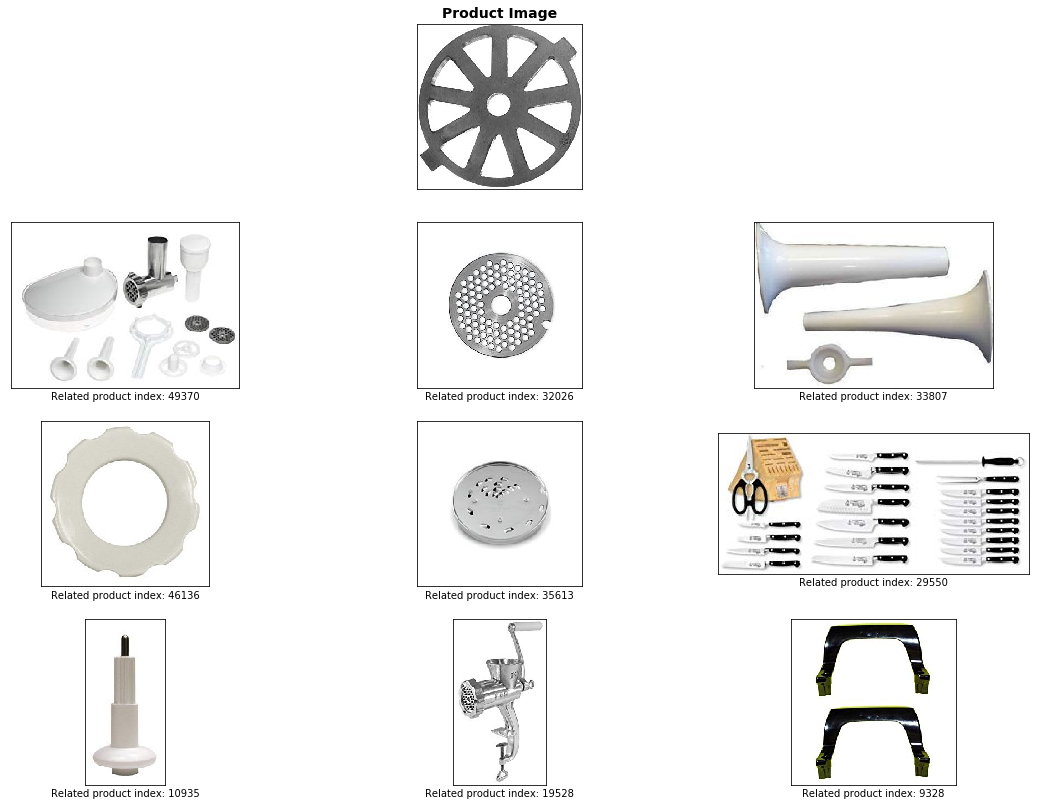

In [64]:
get_related_products(1580)

In [43]:
nums = [3152, 29680, 40138, 43074, 21497, 24420, 24425, 11114, 352]

In [44]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

3152 Atlantic 92835378 Wave 108 CD/72 DVD/BluRay/Games Wire Multimedia Tower Black Steel with Cherry Wood Base

29680 Kaf-979b4 (Successor to Kaf972a4 &middot; Kaf979a4) Antibody Filter Replacement Filter Bio Daikin Daikin Air Purifier

40138 Pentair 27001-0022 1-1/2-Inch NPT Plug Replacement Sta-Rite Pool and Spa Filter (Discontinued by Manufacturer)

43074 Trane/American Standard BAYFRAME235A Frame Kit With Filter

21497 Bryant/Carrier/Payne Fan Coil Filter KFAFK0112SML - 13 x 21 1/ 2 x 1

24420 Vantage Point E322D-B Double Attachment Shelf for Evo System ES Series  - Black

24425 Dometic Microwave Glass Turntable Plate / Tray 13 1/2&quot; A019

11114 Moose Internal Seat Heater 210044

352 Hyper N620 Universal Cooler



In [41]:
new_df['description_final'].loc[38145]

'give little girl extra glamour kidsized fantasy vanity step little makeup hair artist get ready using shatterproof plastic mirror that\'s safe functional vanity features moldedin storage compartments hold makeup accessories working light automatically turns minutes there\'s also pullout drawer desk organizing beauty supplies step fantasy vanity comes threepiece accessory set including hand mirror brush comb beauty supplies sold separately poly construction last years come wipes clean easily minimal assembly required requires "aaa" batteries included'

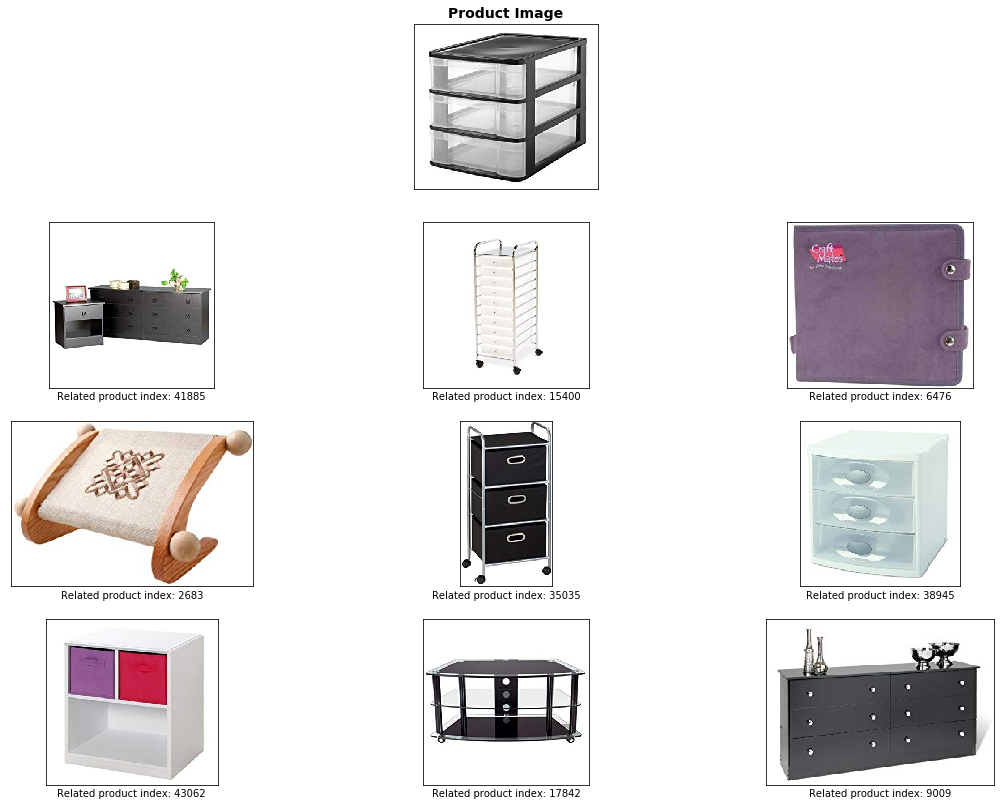

In [43]:
get_related_products(25510)

In [7]:
new_df['title'].loc[35089]

'WearEver 12-Inch Stir Fry'

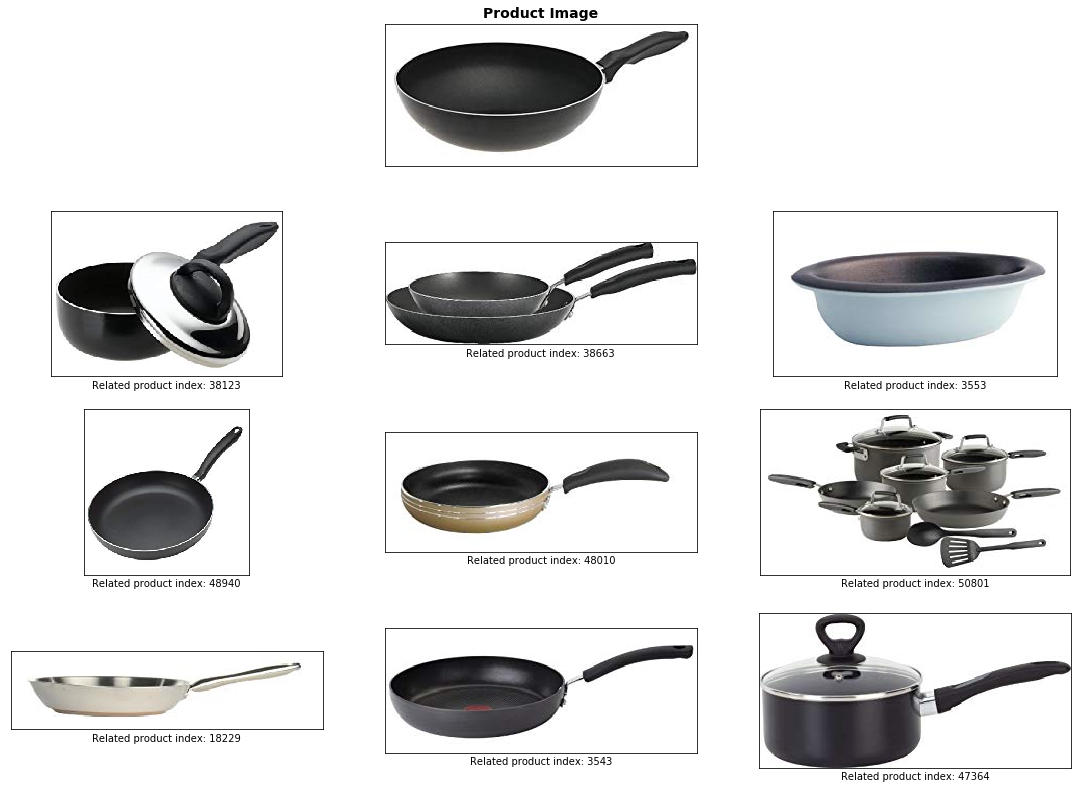

In [75]:
get_related_products(35089)

In [8]:
new_df['title'].loc[5235]

'DEEBOT D77 The 3-D Vacuuming Robot by Ecovacs Robotics, Inc'

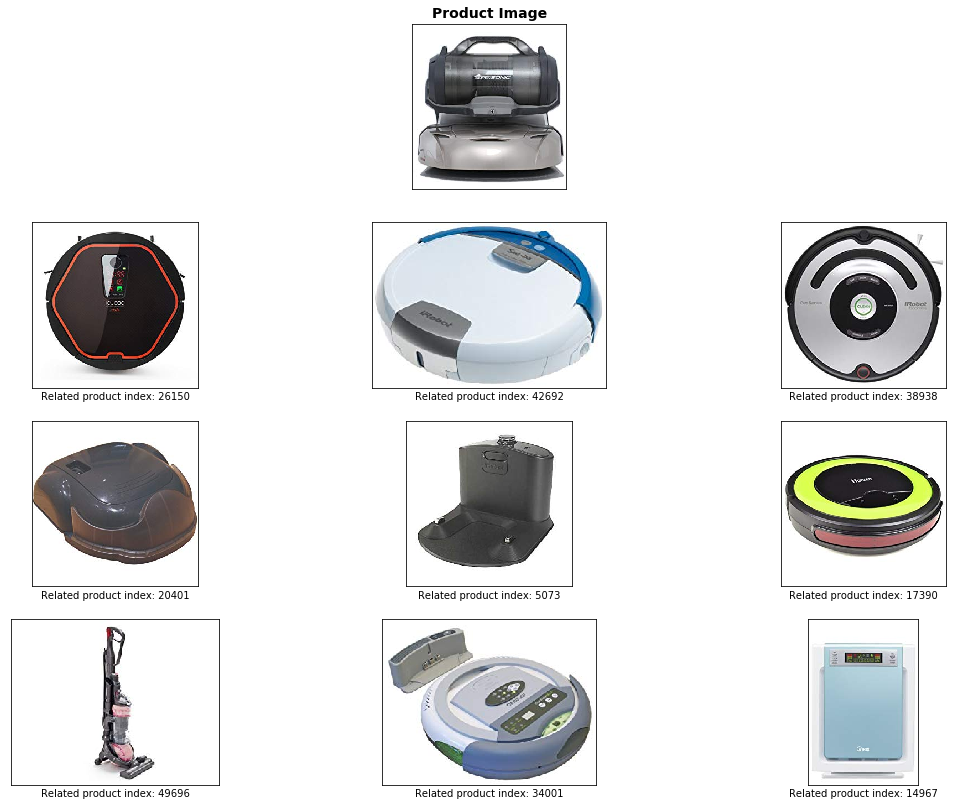

In [47]:
get_related_products(5235)

In [63]:
nums = [1825, 5441]

In [64]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

1825 Infinuvo CleanMate QQ-3 LT Automatic Robotic Vacuum Cleaner with Home Charging Base, Scheduler, Remote Control and UV Disinfection

5441 iRobot Roomba Silver Vacuum - Remanufactured



In [9]:
new_df['title'].loc[35379]

'MaxiMatic EPN-501 Elite Cuisine Electric Panini Grill with Non-Stick, Silver'

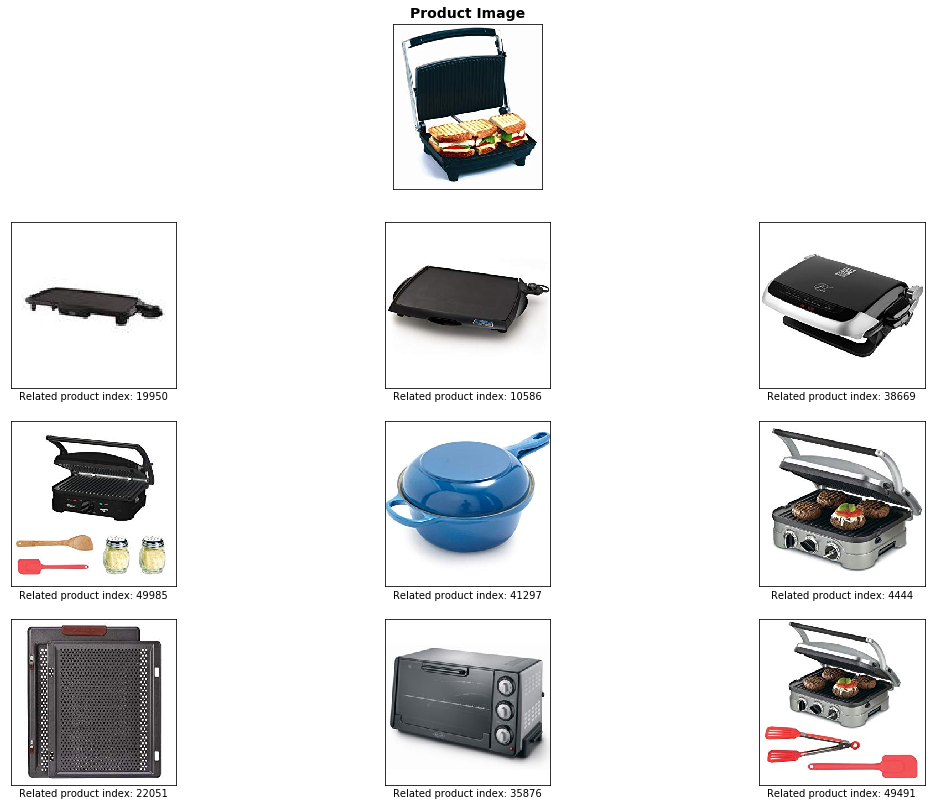

In [48]:
get_related_products(35379)

In [10]:
new_df['title'].loc[19306]

'West Bend 6-Quart Stainless Pressure Cooker'

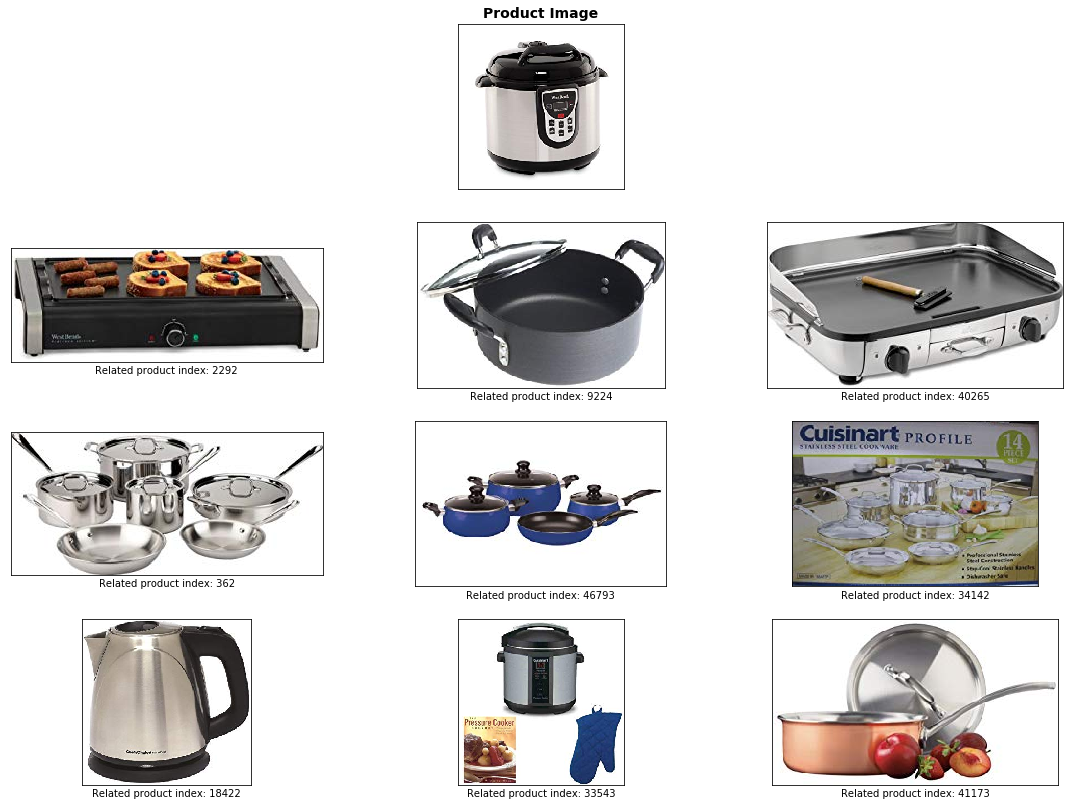

In [49]:
get_related_products(19306)

In [70]:
nums = [41274, 50962, 15974, 3138, 10237]

In [71]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

41274 Lakewood 8250 1000-Watt Fan-Forced Heater with Nano Honeycomb Ceramic Heating Element

50962 KuulAire PACKA45 Portable Evaporative Cooling Unit with 200 Square Foot Cooling Capacity, 375 CFM, Black

15974 Whirlpool 12,000 BTU Portable Air Conditioner with Remote Control, ACP122GPW1

3138 Royal Sovereign ARP-1400BLS Classically Designed 13500 BTU Portable Air Conditioner

10237 Comfort Zone&reg; Citadel Ceramic Tower Heater/Fan CZ444



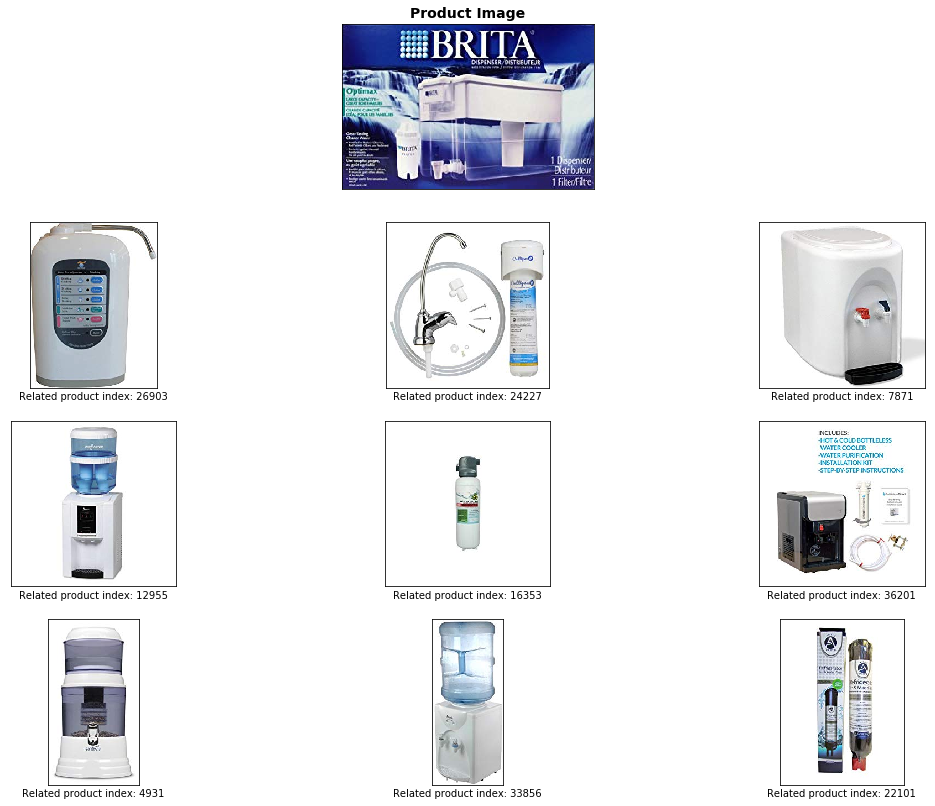

In [51]:
get_related_products(34136)

In [11]:
new_df['title'].loc[43994]

'Carlyle Upholstered Swivel Stool'

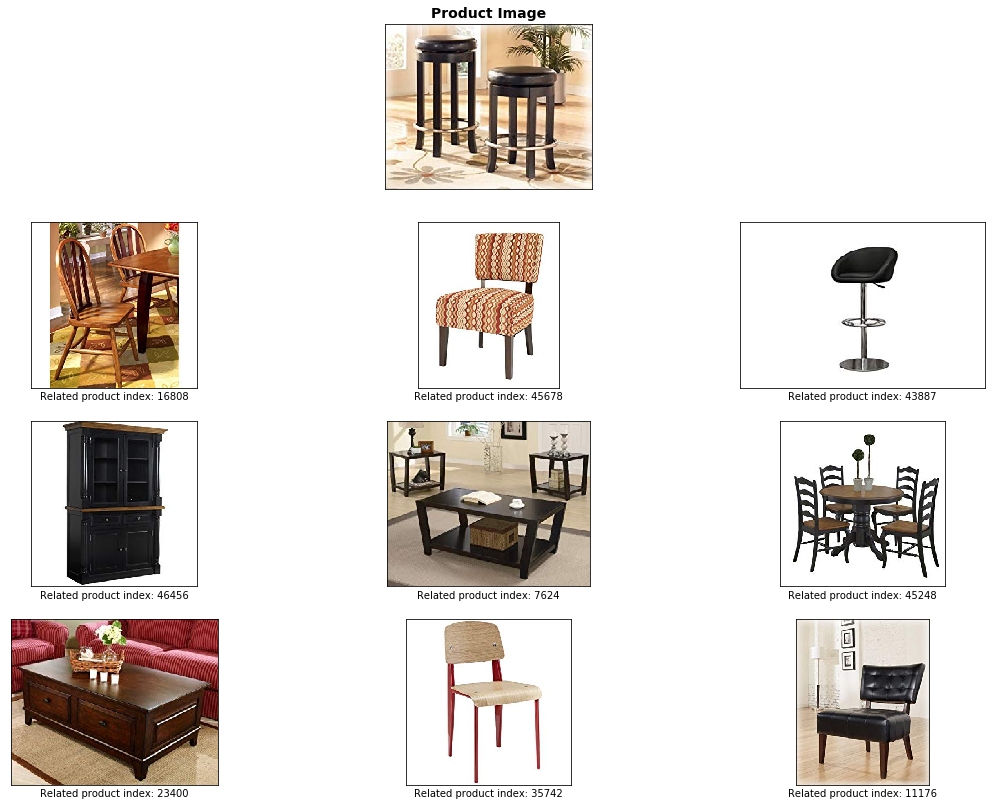

In [55]:
get_related_products(43994)